In [8]:
import requests
import json
import networkx as nx
import matplotlib.pyplot as plt
from  matplotlib.patches import ArrowStyle



In [9]:
# Requests
def call(parameter):
    out = requests.get('http://api.slowosiec.clarin-pl.eu/plwordnet-api/' + parameter)
    return json.loads(out.text)

def sense_from_word(w):
    return call('senses/search?lemma=' + str(w))

def synset_from_sense(s_id):
    return call('senses/' + str(s_id) + '/synset')

def sense_from_synset(s_id):
    return call('synsets/' + str(s_id) + '/senses')

def relation_to(s_id):
    return call('synsets/' + str(s_id) + '/relations/to')
    
def relation_from(s_id):
    return call('synsets/' + str(s_id) + '/relations/from')

def relation_all(s_id):
    return call('synsets/' + str(s_id) + '/relations')



In [10]:
def extract_senses(r):
    return [ (elem['id'],elem['domain']['description']) for elem in r['content']]

def extract_synonyms(r):
    out= []
    for elem in r:
        out.append([subelem['lemma'] for subelem in elem])
    return remove_duplicates(out)
    
def find_synonyms(w):
    return extract_synonyms([sense_from_synset(id_) for id_ in [synset_from_sense(id_)['id'] for id_ in [id_ for id_,desc in extract_senses(sense_from_word(w))]]])

def remove_duplicates(l):
    #set doesn't work with mutable objects :(
    return [ l[i] for i in range(len(l)) if l[i] not in l[i+1:]]

In [11]:
word = "szkoda"
szkoda_senses = sense_from_word(word)
# szkoda_senses

In [12]:
#zad 3a Find all meanings of the szkoda noun
extracted_senses =extract_senses(szkoda_senses)
extracted_senses


[(8769, 'plWN miejsca i umiejscowienie'),
 (8770, 'plWN czasowniki wyrażające uczucia'),
 (8771, 'plWN posiadanie i jego zmiana')]

In [13]:
ids = [ id_ for id_,desc  in extracted_senses]
ids

[8769, 8770, 8771]

In [14]:
ids_2 = [synset_from_sense(id_)['id'] for id_ in ids]
ids_2

[6533, 3411, 3675]

In [15]:
senses = [sense_from_synset(i) for i in ids_2]
senses
synonims = extract_synonyms(senses)
synonims

[[{'id': 249489, 'word': 'szkoda'}],
 [{'id': 249489, 'word': 'szkoda'},
  {'id': 300109, 'word': 'żałować'},
  {'id': 300080, 'word': 'żal'}],
 [{'id': 243080, 'word': 'strata'},
  {'id': 270916, 'word': 'utrata'},
  {'id': 249489, 'word': 'szkoda'},
  {'id': 270658, 'word': 'uszczerbek'}]]

In [16]:
#let's just copy this whole comprehensions to one line
find_synonyms('szkoda')

[[{'id': 249489, 'word': 'szkoda'}],
 [{'id': 249489, 'word': 'szkoda'},
  {'id': 300109, 'word': 'żałować'},
  {'id': 300080, 'word': 'żal'}],
 [{'id': 243080, 'word': 'strata'},
  {'id': 270916, 'word': 'utrata'},
  {'id': 249489, 'word': 'szkoda'},
  {'id': 270658, 'word': 'uszczerbek'}]]

In [17]:
#zad hypernymy
word = "wypadek drogowy"

res = extract_senses(sense_from_word(word))
id_=res[0][0]
ids = [synset_from_sense(id_)['id']]
for id_i in ids: 
    candidates=relation_from(id_i)
    ids.extend([c['synsetTo']['id'] for c in candidates\
            if c['relation']['name'] == 'hiponimia' and c['synsetTo']['id'] not in ids])    
# print(ids)
out = []
for id_i in ids:
    sense = sense_from_synset(id_i)
    out.append([(sense['lemma'],sense['id']) for sense in sense])
#out
hypernymy_full_relations = out
hypernymy_full_relations


[[({'id': 286392, 'word': 'wypadek drogowy'}, 644786)],
 [({'id': 286393, 'word': 'wypadek komunikacyjny'}, 644778)],
 [({'id': 286391, 'word': 'wypadek'}, 21890)],
 [({'id': 294893, 'word': 'zdarzenie oceniane negatywnie'}, 43277)],
 [({'id': 284803, 'word': 'wydarzenie'}, 10240),
  ({'id': 101333, 'word': 'historia'}, 69513),
  ({'id': 286391, 'word': 'wypadek'}, 69514),
  ({'id': 294891, 'word': 'zdarzenie'}, 69515)]]

{('`wypadek drogowy`',
  '`wypadek komunikacyjny`'): Text(0.5408241255722683, 0.7470928345580601, ''),
 ('`wypadek komunikacyjny`',
  '`wypadek`'): Text(0.1858665260528608, 0.24499922228401252, ''),
 ('`wypadek`',
  '`zdarzenie oceniane negatywnie`'): Text(-0.17607617366196732, -0.25210324546737073, ''),
 ('`zdarzenie oceniane negatywnie`',
  '`wydarzenie` `historia` `wypadek` `zdarzenie`'): Text(-0.5437049823085958, -0.7449992222840125, '')}

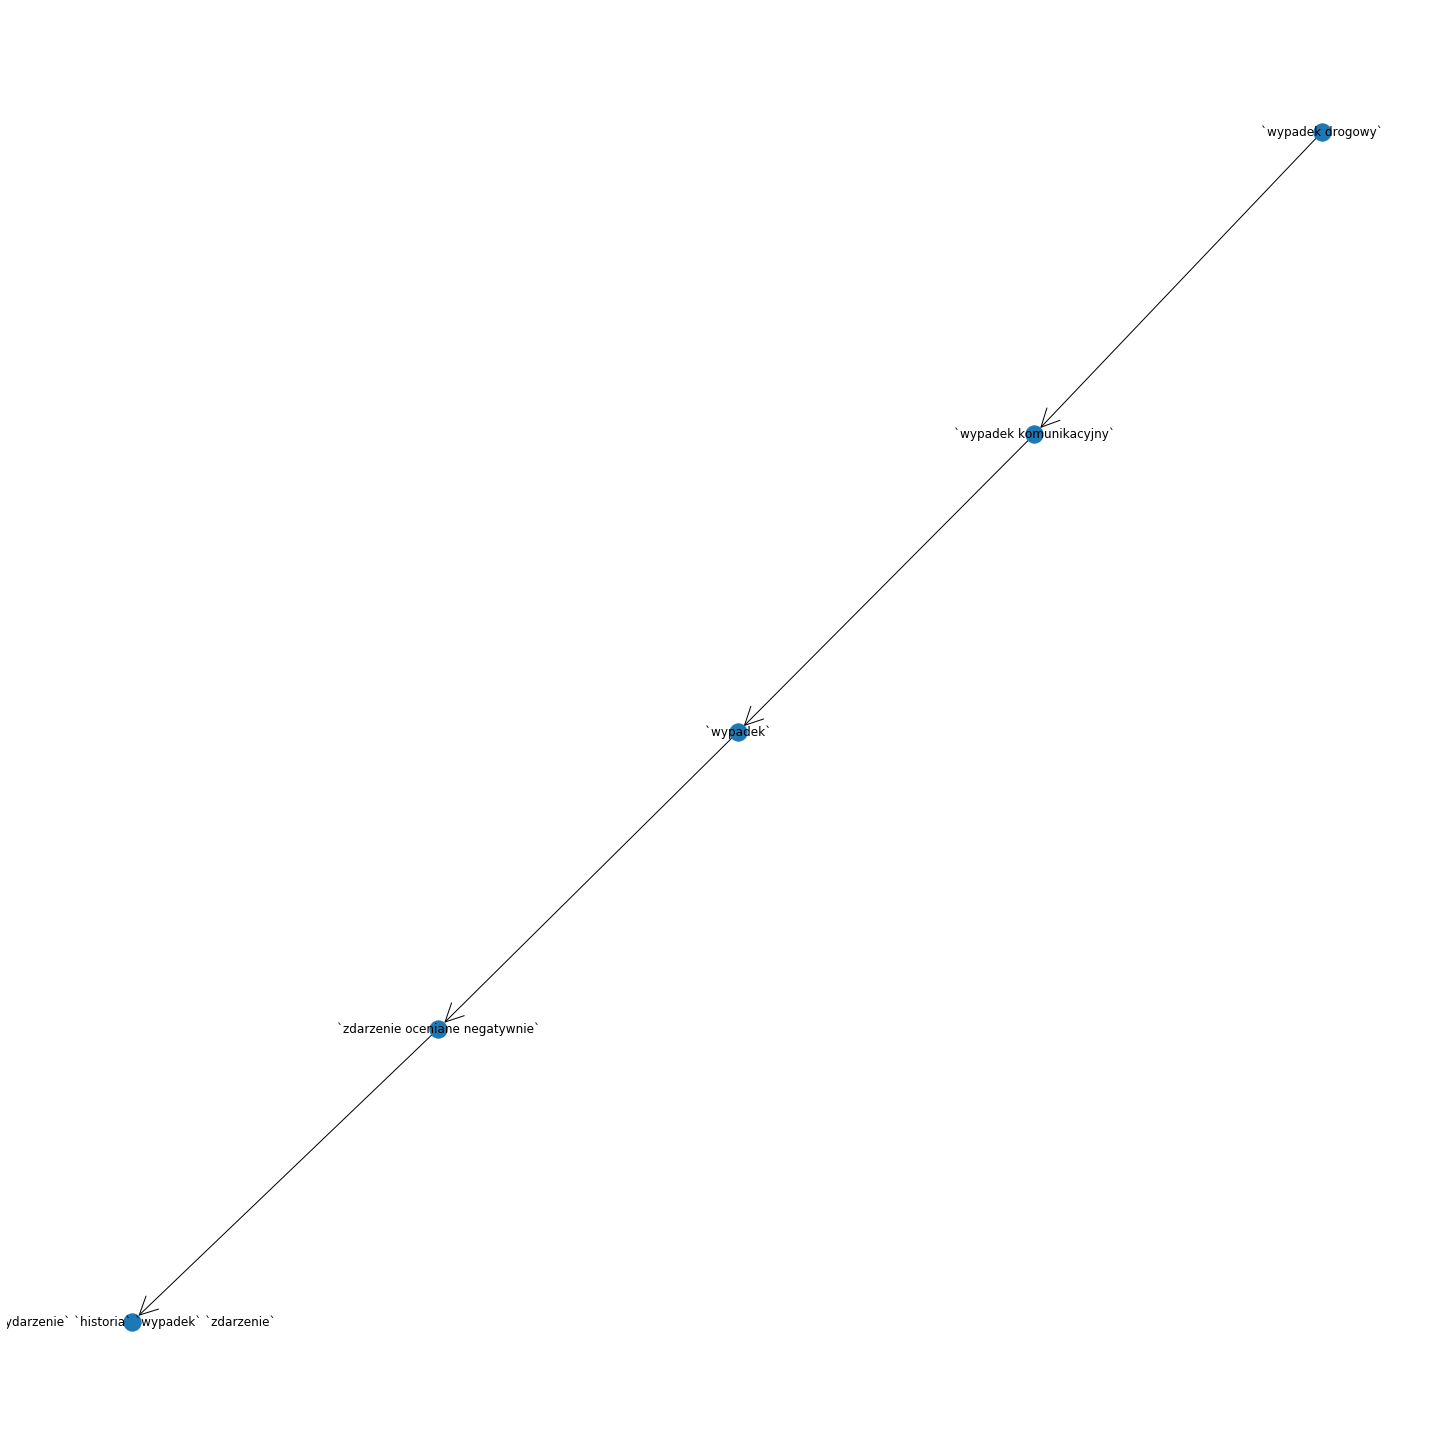

In [18]:
edges = []
edges_labels = {}
for i in range(1,len(hypernymy_full_relations)):
    n1 = ' '.join([ '`'+hypernim[0]['word']+'`' for hypernim in hypernymy_full_relations[i-1]])
    n2 = ' '.join([ '`'+hypernim[0]['word']+'`' for hypernim in hypernymy_full_relations[i]])
    edges += [(n1,n2)]
    edges_labels[(n1,n2)] = ''

G = nx.DiGraph()
G.add_edges_from(edges)

plt.figure(figsize=(20,20))
pos = nx.kamada_kawai_layout(G)
nx.draw(G,pos, labels={node:node for node in G.nodes()}, arrowsize=45\
    , arrowstyle=ArrowStyle("->"))
nx.draw_networkx_edge_labels(G, pos, edge_labels=edges_labels)

In [19]:
#zad 5
word = "wypadek"
def get_hiperonims(word, id_in= None,meaning_idx = 0):
    ids = None
    if id_in is not None:
        pass
        print('hue')
        ids = [synset_from_sense(id_in)['id']]
    else:
        res = extract_senses(sense_from_word(word))
        id_=res[meaning_idx][0]
        ids = [synset_from_sense(id_)['id']]
    ids_2 = []
    for id_i in ids: 
        candidates=relation_from(id_i)
        ids_2.extend([c['synsetTo']['id'] for c in candidates\
                if c['relation']['name'] == 'hiperonimia' and c['synsetTo']['id'] not in ids])    
    # print(ids)
    out = []
    for id_i in ids_2:
        sense = sense_from_synset(id_i)
        out.append([(sense['lemma'],sense['id']) for sense in sense])
    #out
    hiperonimy_full_relations = out
    return hiperonimy_full_relations


hiperonimy_full_relations= get_hiperonims(word)
hiperonimy_full_relations

[[({'id': 294092, 'word': 'zawał'}, 52898)],
 [({'id': 253959, 'word': 'tąpnięcie'}, 52894)],
 [({'id': 117781, 'word': 'katastrofa'}, 19923)],
 [({'id': 285527, 'word': 'wykolejenie'}, 393642)],
 [({'id': 291365, 'word': 'zakrztuszenie'}, 618773),
  ({'id': 289786, 'word': 'zachłyśnięcie'}, 618779)],
 [({'id': 286393, 'word': 'wypadek komunikacyjny'}, 644778)],
 [({'id': 117782, 'word': 'katastrofa budowlana'}, 645560)]]

{('wypadek',
  '`tąpnięcie`'): Text(0.47939993331712566, 0.48928013791466846, ''),
 ('wypadek',
  '`katastrofa`'): Text(0.07691915148536507, 0.4999999610034042, ''),
 ('wypadek',
  '`wykolejenie`'): Text(-0.2251282742358568, 0.21261622494826393, ''),
 ('wypadek',
  '`zakrztuszenie` `zachłyśnięcie`'): Text(-0.22512828556233377, -0.2126162661250524, ''),
 ('wypadek',
  '`wypadek komunikacyjny`'): Text(0.07691912904219755, -0.500000019730657, ''),
 ('wypadek',
  '`katastrofa budowlana`'): Text(0.47939986931661693, -0.4892802329936059, '')}

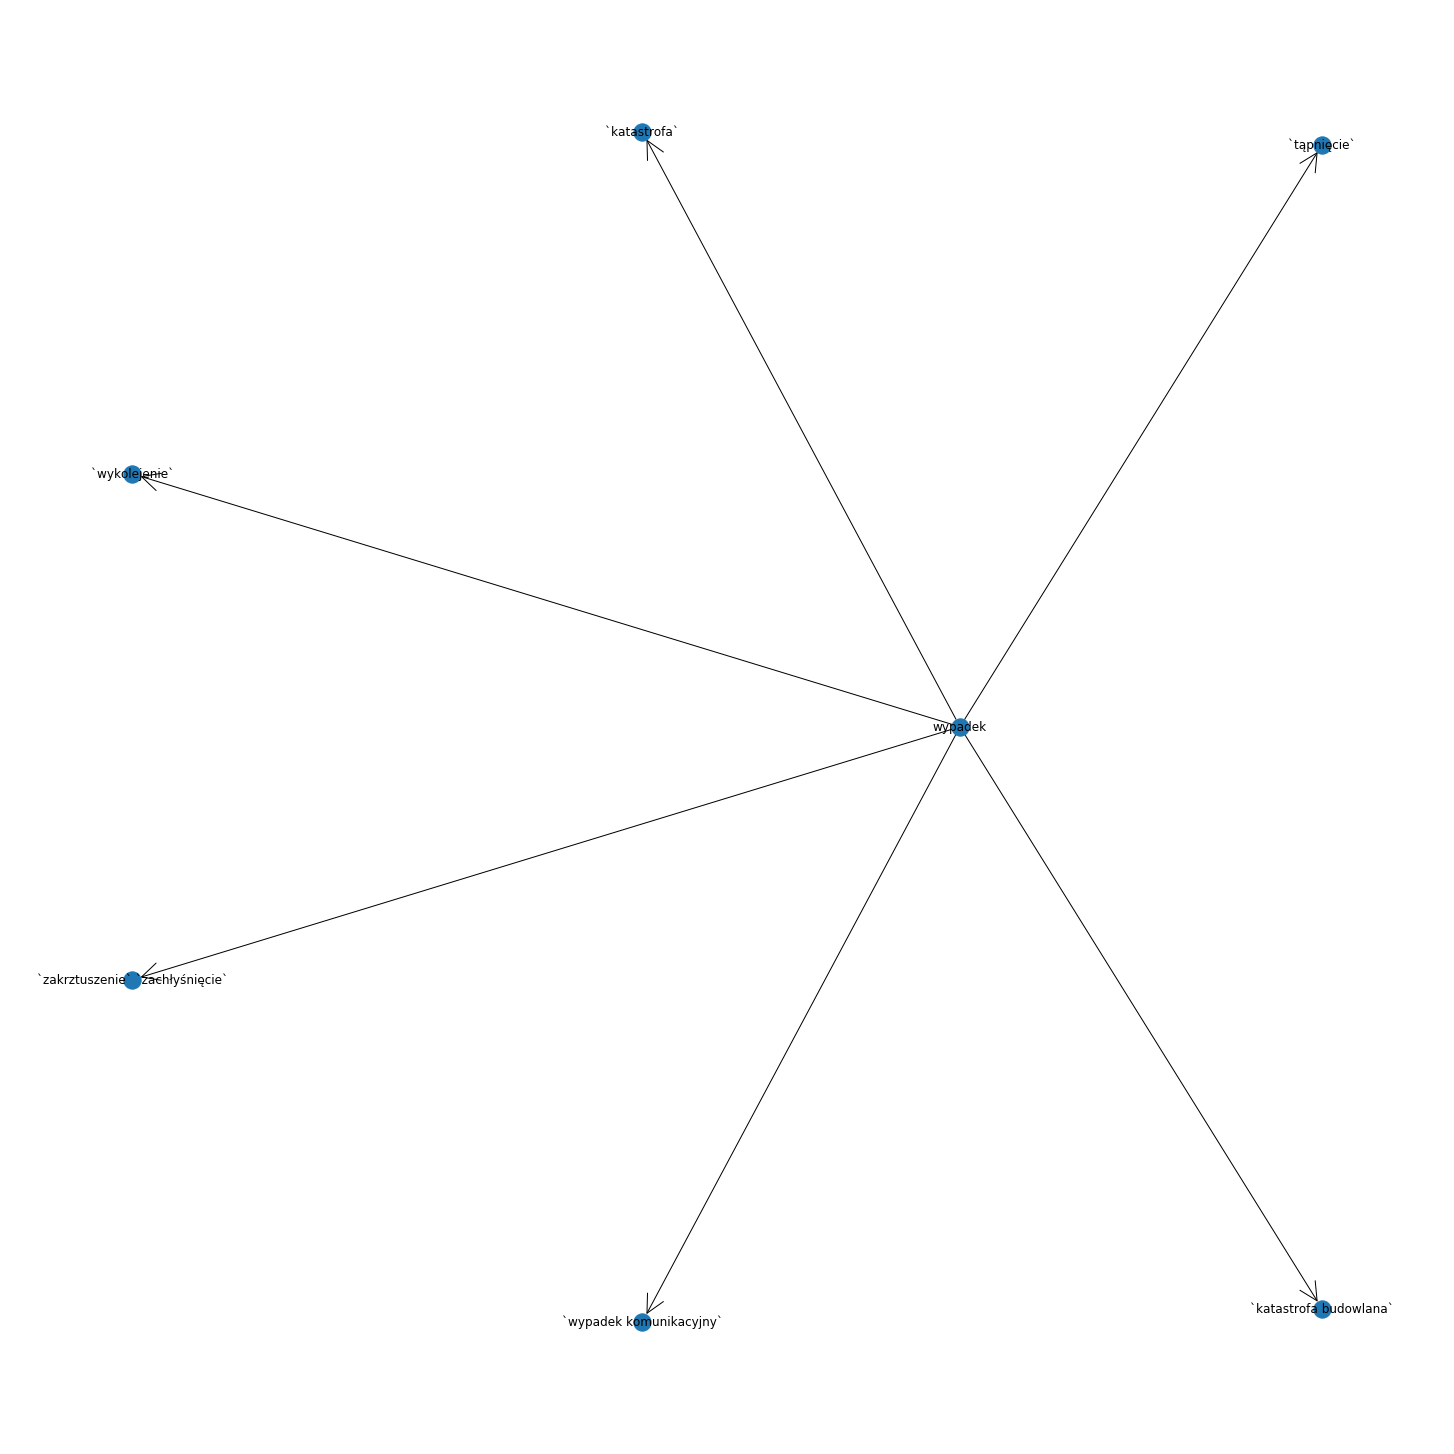

In [20]:
edges = []
edges_labels = {}
n1 = 'wypadek'
for i in range(1,len(hiperonimy_full_relations)):
    n2 = ' '.join([ '`'+hiperonim[0]['word']+'`' for hiperonim in hiperonimy_full_relations[i]])
    edges += [(n1,n2)]
    edges_labels[(n1,n2)] = ''

G = nx.DiGraph()
G.add_edges_from(edges)

plt.figure(figsize=(20,20))
pos = nx.kamada_kawai_layout(G)
nx.draw(G,pos, labels={node:node for node in G.nodes()}, arrowsize=45\
    , arrowstyle=ArrowStyle("->"))
nx.draw_networkx_edge_labels(G, pos, edge_labels=edges_labels)

In [21]:
def get_hiperonims_2(ids_in):
    ids =  [synset_from_sense(i)['id'] for i in ids_in]
    
    for id_i in ids: 
        candidates=relation_from(id_i)
        ids.extend([c['synsetTo']['id'] for c in candidates\
                if c['relation']['name'] == 'hiperonimia' and c['synsetTo']['id'] not in ids])    
    # print(ids)
    out = []
    for id_i in ids:
        sense = sense_from_synset(id_i)
        out.append([(sense['lemma'],sense['id']) for sense in sense])
    #out
    hiperonimy_full_relations = out
    return hiperonimy_full_relations

In [32]:
hiperonimy_full_relations_flattened

[({'id': 294092, 'word': 'zawał'}, 52898),
 ({'id': 253959, 'word': 'tąpnięcie'}, 52894),
 ({'id': 117781, 'word': 'katastrofa'}, 19923),
 ({'id': 285527, 'word': 'wykolejenie'}, 393642),
 ({'id': 291365, 'word': 'zakrztuszenie'}, 618773),
 ({'id': 289786, 'word': 'zachłyśnięcie'}, 618779),
 ({'id': 286393, 'word': 'wypadek komunikacyjny'}, 644778),
 ({'id': 117782, 'word': 'katastrofa budowlana'}, 645560)]

In [33]:


hiperonimy_full_relations_flattened = [single_hiper for hiper in hiperonimy_full_relations for single_hiper in hiper]

first_order_hyponyms = hiperonimy_full_relations_flattened

hiperonim_second_tier = []

for hiper in hiperonimy_full_relations_flattened:
    candidates = get_hiperonims(hiper[0]['word'])
    hiperonim_second_tier += [(j,c) for c in candidates if c not in first_order_hyponyms]
hiperonim_second_tier = [a for subl in hiperonim_second_tier for a in subl]


In [34]:
hiperonim_second_tier

[({'id': 117782, 'word': 'katastrofa budowlana'}, 645560),
 [({'id': 193185, 'word': 'porażka'}, 6044),
  ({'id': 201126, 'word': 'przegrana'}, 6698),
  ({'id': 120094, 'word': 'klęska'}, 2568)],
 ({'id': 117782, 'word': 'katastrofa budowlana'}, 645560),
 [({'id': 243080, 'word': 'strata'}, 8495),
  ({'id': 270916, 'word': 'utrata'}, 9582),
  ({'id': 249489, 'word': 'szkoda'}, 8771),
  ({'id': 270658, 'word': 'uszczerbek'}, 29762)],
 ({'id': 117782, 'word': 'katastrofa budowlana'}, 645560),
 [({'id': 282623, 'word': 'wpadka'}, 29789),
  ({'id': 284020, 'word': 'wtopa'}, 380288)],
 ({'id': 117782, 'word': 'katastrofa budowlana'}, 645560),
 [({'id': 9982, 'word': 'antysztuka'}, 632590)],
 ({'id': 117782, 'word': 'katastrofa budowlana'}, 645560),
 [({'id': 205996, 'word': 'pudło'}, 638085)],
 ({'id': 117782, 'word': 'katastrofa budowlana'}, 645560),
 [({'id': 295497, 'word': 'zepsucie'}, 11508),
  ({'id': 217490, 'word': 'rozkład'}, 7520),
  ({'id': 217492, 'word': 'rozkład moralny'}, 752

In [35]:
#zad 6
hiperonim_second_tier_tmp = []
for elem in hiperonim_second_tier:
    if elem.__class__ == [].__class__:
        hiperonim_second_tier_tmp.extend(elem)
    else:
        hiperonim_second_tier_tmp.append(elem)
hiperonim_second_tier_tmp    
second_order_hyponyms_final  = remove_duplicates(hiperonim_second_tier_tmp)
second_order_hyponyms_final

[({'id': 193185, 'word': 'porażka'}, 6044),
 ({'id': 201126, 'word': 'przegrana'}, 6698),
 ({'id': 120094, 'word': 'klęska'}, 2568),
 ({'id': 243080, 'word': 'strata'}, 8495),
 ({'id': 270916, 'word': 'utrata'}, 9582),
 ({'id': 249489, 'word': 'szkoda'}, 8771),
 ({'id': 270658, 'word': 'uszczerbek'}, 29762),
 ({'id': 282623, 'word': 'wpadka'}, 29789),
 ({'id': 284020, 'word': 'wtopa'}, 380288),
 ({'id': 9982, 'word': 'antysztuka'}, 632590),
 ({'id': 205996, 'word': 'pudło'}, 638085),
 ({'id': 295497, 'word': 'zepsucie'}, 11508),
 ({'id': 217490, 'word': 'rozkład'}, 7520),
 ({'id': 217492, 'word': 'rozkład moralny'}, 7523),
 ({'id': 240140, 'word': 'staczanie się'}, 8371),
 ({'id': 269128, 'word': 'upadek'}, 9420),
 ({'id': 53828, 'word': 'degrengolada'}, 1031),
 ({'id': 8960, 'word': 'anomia'}, 108727),
 ({'id': 117782, 'word': 'katastrofa budowlana'}, 645560),
 ({'id': 286392, 'word': 'wypadek drogowy'}, 644786)]

In [24]:
#zad 7 Display as a directed graph (with labels for the edges) semantic relations between the following groups of lexemes

ex1 = [('szkoda',2),('strata',1),('uszczerbek',1),('szkoda majątkowa',1),('uszczerbek na zdrowiu',1),('krzywda',1),('niesprawiedliwość',1),('nieszczęście',2)]
ex2 = [('wypadek',1), ('wypadek komunikacyjny',1), ('kolizja',2), ('zderzenie',2), ('kolizja drogowa',1), ('bezkolizyjny',2), ('katastrofa budowlana',1), ('wypadek drogowy',1)]



In [25]:
def draw_relation_graph(words):
    senses = [ (word,extract_senses(sense_from_word(word)),i) for word,i in words]
    print(senses)
    print('\n')
    senses = list(map(lambda x: (x[0],x[1][x[2]-1]),filter(lambda x: len(x[1])> 0,senses)))
    print(senses)
    print('\n')
    synsets =  [ (w,synset_from_sense(s[0])['id']) for w,s in senses] #get rigght meaning
    print(synsets)
    print('\n')
    #get id based search easy
    synsets_as_dict = {}
    for syn in synsets:
        if syn[1] in synsets_as_dict:
            synsets_as_dict[syn[1]].append(syn[0])
        else:
            synsets_as_dict[syn[1]] = [syn[0]] 
    print(synsets_as_dict)
    print('\n')
    #gather all relations from and to our words
    all_relations = {}
    for id_,words in synsets_as_dict.items():
        relations = relation_to(id_)
        tmp = []
        for relation in relations:
            type_  = relation['relation']['name']
            if type_ != 'hiponimia':
                continue
            from_ = relation['synsetFrom']["id"]
            to_ = relation['synsetTo']["id"]
            tmp.append((from_,to_,type_))
        all_relations[id_]  = (words,tmp)
    print(all_relations)
    print('\n')
    
    edges = []
    edges_labels = {}
    for id_, (words,rels) in all_relations.items():
        if len(rels) == 0:
            continue
        n1 = ' '.join(['`'+word+'`' for word in words])
        for from_,to_,type_ in rels:
            try:
                words_from,_ = all_relations[from_]
                n2 = ' '.join(['`'+word+'`' for word in words_from])
                edges.append((n1,n2))
                edges_labels[(n1,n2)] = ''
            except KeyError:#ignore not used words
                pass
    
    G = nx.DiGraph()
    G.add_edges_from(edges)

    plt.figure(figsize=(20,20))
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G,pos, labels={node:node for node in G.nodes()}, arrowsize=45\
        , arrowstyle=ArrowStyle("->"))
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edges_labels)    


[('szkoda', [(8769, 'plWN miejsca i umiejscowienie'), (8770, 'plWN czasowniki wyrażające uczucia'), (8771, 'plWN posiadanie i jego zmiana')], 2), ('strata', [(8495, 'plWN zdarzenia'), (367404, 'plWN związane z porozumiewaniem się'), (643714, 'plWN związek miedzy ludźmi, rzeczami lub ideami'), (436130, 'PWN czynności (nazwy)'), (491455, 'PWN związane z myśleniem')], 1), ('uszczerbek', [(29762, 'plWN zdarzenia'), (67978, 'plWN zdarzenia')], 1), ('szkoda majątkowa', [], 1), ('uszczerbek na zdrowiu', [(67978, 'plWN zdarzenia')], 1), ('krzywda', [(2967, 'plWN uczucia, odczucia i emocje')], 1), ('niesprawiedliwość', [(4278, 'plWN cechy ludzi i zwierząt'), (12796, 'plWN zdarzenia')], 1), ('nieszczęście', [(4295, 'plWN zdarzenia'), (12324, 'plWN uczucia, odczucia i emocje')], 2)]


[('szkoda', (8770, 'plWN czasowniki wyrażające uczucia')), ('strata', (8495, 'plWN zdarzenia')), ('uszczerbek', (29762, 'plWN zdarzenia')), ('uszczerbek na zdrowiu', (67978, 'plWN zdarzenia')), ('krzywda', (2967, 'p

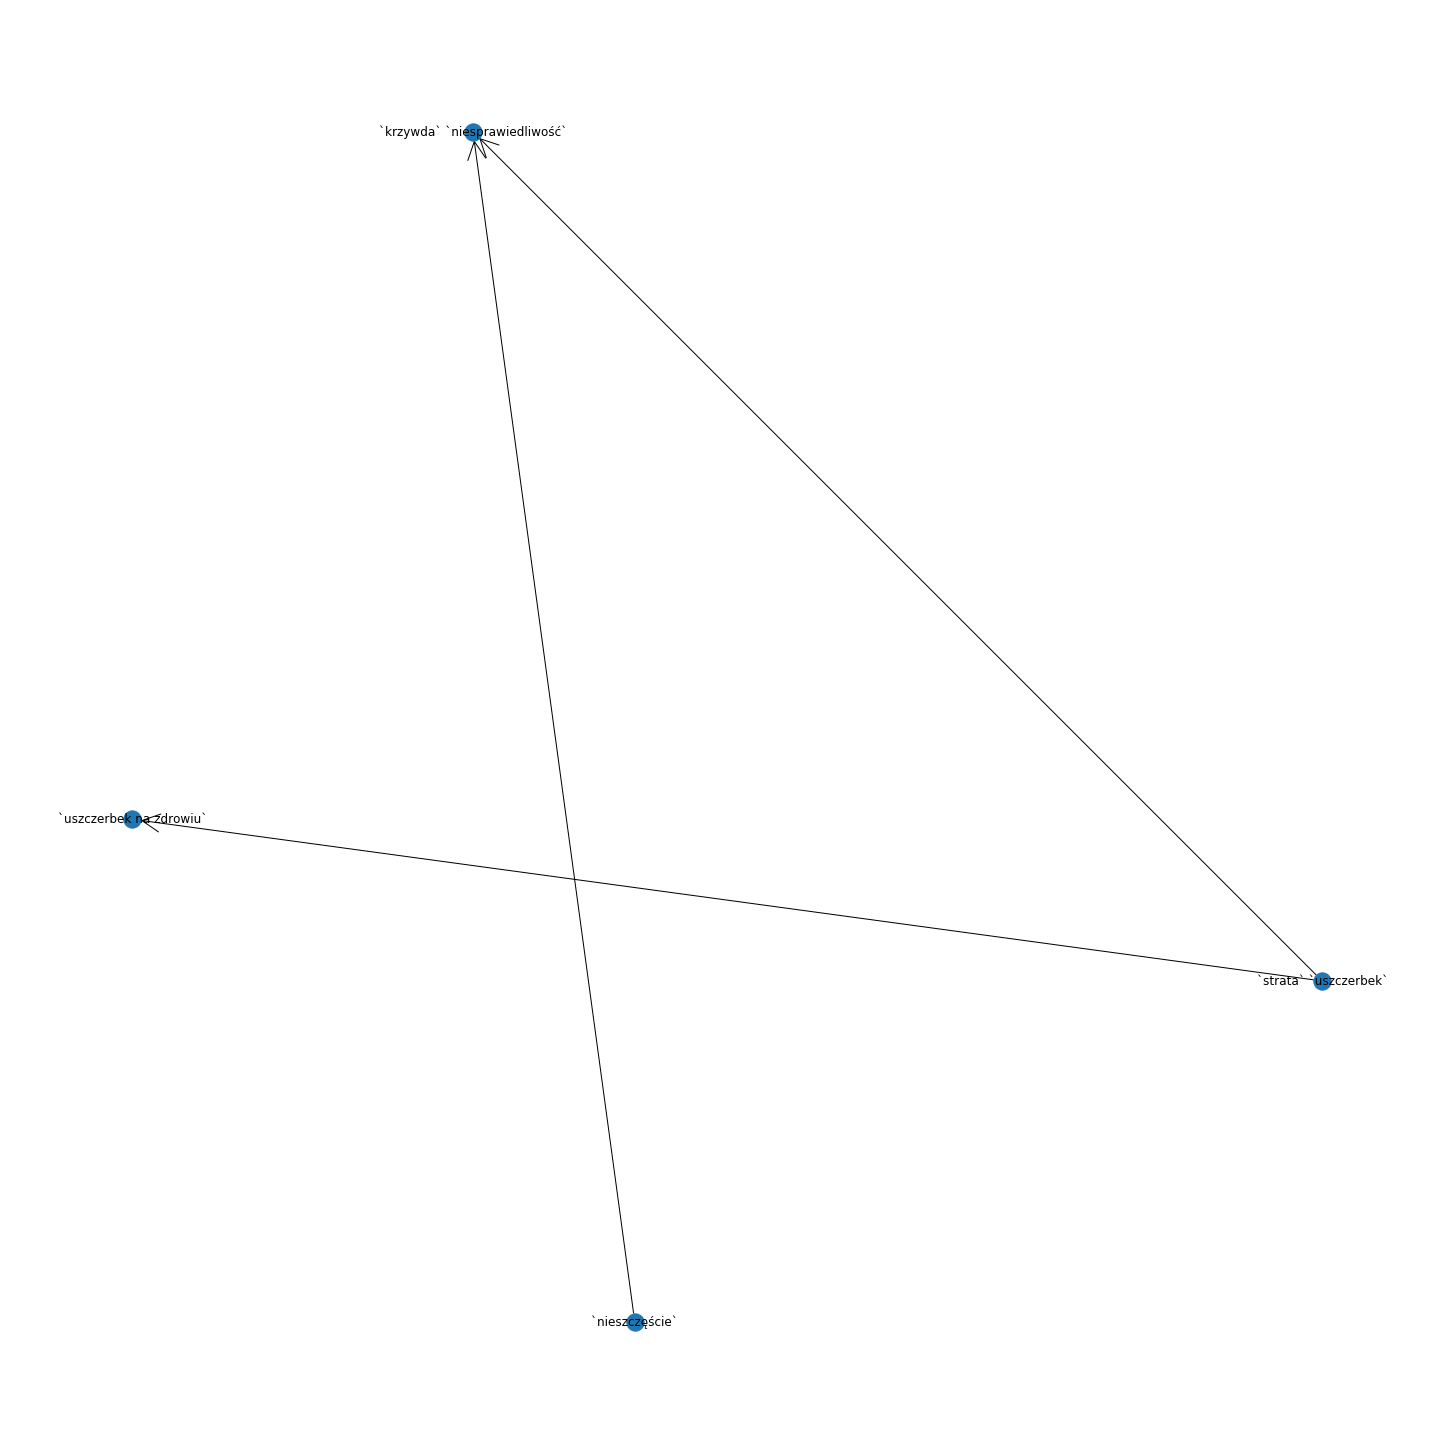

In [26]:
draw_relation_graph(ex1)

[('wypadek', [(21890, 'plWN zdarzenia'), (10426, 'plWN zdarzenia'), (69514, 'plWN zdarzenia'), (644786, 'plWN zdarzenia'), (644778, 'plWN zdarzenia'), (30231, 'plWN zdarzenia'), (67996, 'plWN zdarzenia'), (67995, 'plWN sytuacje statyczne (stany)')], 1), ('wypadek komunikacyjny', [(644778, 'plWN zdarzenia')], 1), ('kolizja', [(2638, 'plWN cechy ludzi i zwierząt'), (2639, 'plWN zdarzenia'), (645561, 'plWN zdarzenia')], 2), ('zderzenie', [(136395, 'plWN zdarzenia'), (11447, 'plWN zdarzenia'), (648908, 'plWN zdarzenia'), (141381, 'plWN zdarzenia'), (136989, 'plWN zdarzenia')], 2), ('kolizja drogowa', [(645561, 'plWN zdarzenia')], 1), ('bezkolizyjny', [(359275, 'plWN przymiotniki jakościowe'), (359276, 'plWN przymiotniki jakościowe'), (359277, 'plWN przymiotniki jakościowe')], 2), ('katastrofa budowlana', [(645560, 'plWN zdarzenia')], 1), ('wypadek drogowy', [(644786, 'plWN zdarzenia')], 1)]


[('wypadek', (21890, 'plWN zdarzenia')), ('wypadek komunikacyjny', (644778, 'plWN zdarzenia')), ('

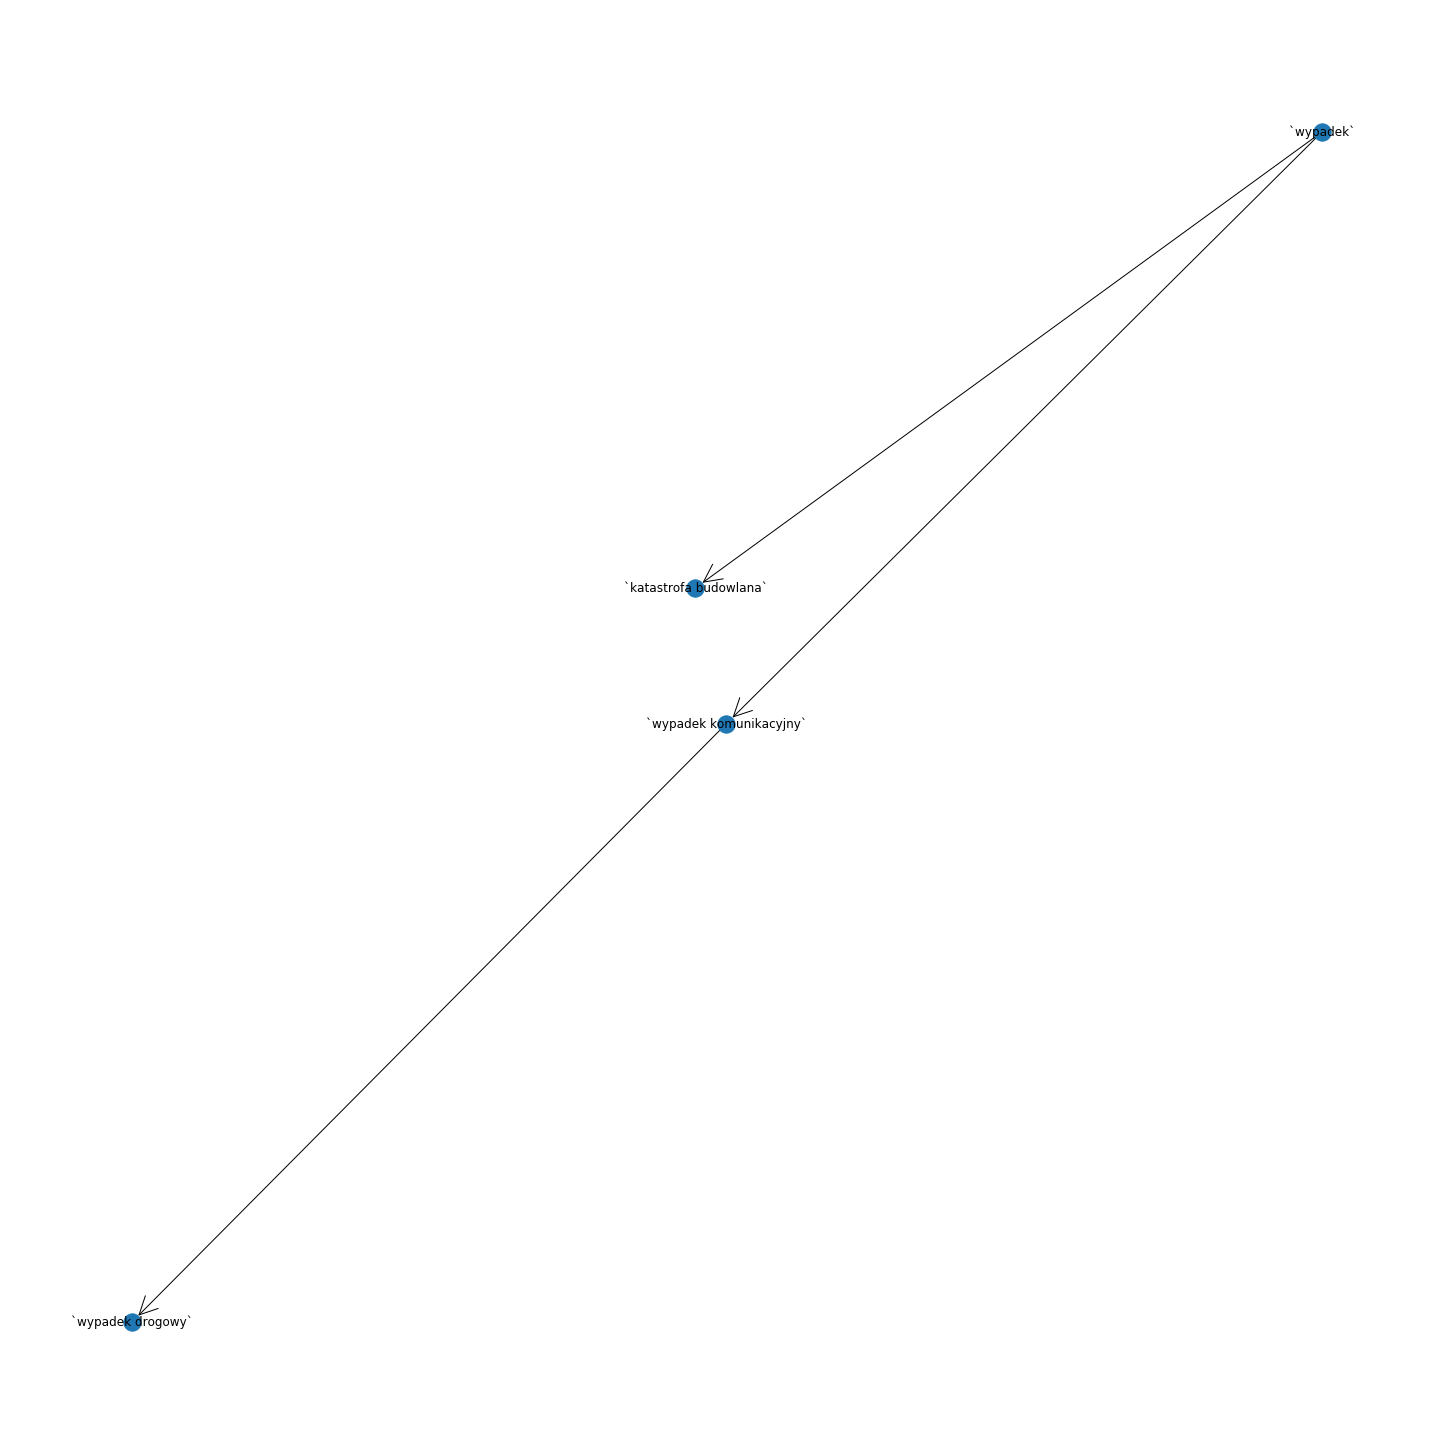

In [27]:
draw_relation_graph(ex2)

In [28]:
from math import log
import queue


word_pairs = [(('szkoda',2), ('wypadek',1)) ,(('kolizja',2), ('szkoda majątkowa',1))\
              ,(('nieszczęście',2), ('katastrofa budowlana',1))]

def _find_relation_distance(s1,s2,max_dist = 10):
    if s1==s2:
        return 0
    pq = queue.PriorityQueue()
    pq.put((0,s1))
    visited = set()
    while  not pq.empty():
        distance, id_ = pq.get()
        if id_ not in visited:
            visited.add(id_)
            relations = relation_all(id_)
            for rel in relations:
                from_ = rel['synsetFrom']
                to_ = rel['synsetTo']
                if from_['id'] == s2 or to_['id'] == s2:
                    return distance + 1
                if distance < max_dist:
                    if to_['id']:
                        pq.put((distance+1,to_['id']))
                    if from_['id']:
                        pq.put((distance+1,from_['id']))
    return -1

def _lc_measure(dist,max_dist):
    return -log((dist + 1) / (2.0 * max_dist))


def LC(word_pair,max_dist = 20):
    w1,m_id1 = word_pair[0]
    w2,m_id2 = word_pair[1]
    try:
        sense1 = extract_senses(sense_from_word(w1))[m_id1-1]
        sense2 = extract_senses(sense_from_word(w2))[m_id2-1]
    except IndexError:
        raise  ValueError('invalid meaning id / sense could not be found')
#     print(sense1)
#     print('\n')
#     print(sense2)
#     print('\n')
    syn1 = synset_from_sense(sense1[0])
    syn2 = synset_from_sense(sense2[0])
#     print(syn1)
#     print('\n')
#     print(syn2)
#     print('\n')
    dist = _find_relation_distance(syn1['id'],syn2['id'], max_dist=max_dist)
#     print(dist)
#     print('\n')
    if dist < 0:
        raise ValueError('could not find relation distance')
    if dist == 0:
        return float('inf') 
    return (_lc_measure(dist,max_dist),dist)


In [29]:
for word_pair in word_pairs:
    try:
        lc_score = LC(word_pair)
        print(' lc score for {} and {} is {} with distance {}'.format(word_pair[0],word_pair[1],lc_score[0],lc_score[1]))
    except ValueError as e:
        print(' lc score for {} and {} couldnot be found'.format(word_pair[0],word_pair[1]))


 lc score for ('szkoda', 2) and ('wypadek', 1) is 1.8971199848858813 with distance 5
 lc score for ('kolizja', 2) and ('szkoda majątkowa', 1) couldnot be found
 lc score for ('nieszczęście', 2) and ('katastrofa budowlana', 1) is 1.8971199848858813 with distance 5


###### What is the necessary step to use the knowlege from dictionaries such as WordNet?

To learn api, and how the dictionary is constructed. You also probably may want to know which meaning of given word you are intersted with. Another point is to be able to do something with returned data.


###### Assess the value of WordNet as a resource for representing the sense of sentences (not words in isolation).
It seems to be a good tool, cause you can try to find meaning of given words via their connections. Or se how related they are. Geting meaning of subject and predicate can tell you most of meaning of givenm seneence.



###### Discuss the problmes comming from using structured knowledge resources such as WordNet.
It's quite time consuming to learng api, which id goes where etc. Also analysis requires quite a few calls to their API, which i noticed to be somewhat timeconsuming. Also gathering feeling on how to use wordnet take a while of experimentation, after just knowing calls to API
